In [3]:
import hail as hl
import os

localfs_path = os.environ.get('SCRATCH') + '/hail-temp/'
hl.init(tmp_dir=localfs_path, local_tmpdir=localfs_path, 
        spark_conf={'spark.driver.memory': '15G', 'spark.executor.memory': '30G'})

2024-01-08 13:26:18.541 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.1.3
SparkUI available at http://ac0026:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.109-b71b065e4bb6
LOGGING: writing to /net/pr2/projects/plgrid/plggneuromol/imdik-zekanowski-sportwgs/analysis/variant-analysis-and-exports/hail-20240108-1326-0.2.109-b71b065e4bb6.log


In [4]:
import seaborn as sns

In [5]:
from hail.plot import show
from pprint import pprint
from bokeh.layouts import gridplot
hl.plot.output_notebook()


import numpy as np
import pandas as pd
from functools import reduce
from itertools import chain

from bokeh.plotting import output_notebook, show, figure
from bokeh.palettes import viridis
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection

output_notebook()

Loading BokehJS ...

Loading BokehJS ...

### Phenotypes to investigate and their respective phenotypes in genebass:


Many of the phenotypes do not have their exact respective phenotypes, so the closest phenotype was chosen:

panukb phenotype | genebass phenotype
--------------- | ------------------
anti_gout_agent_microtuble_polymerization_inhibitor-both_sexes | none
allopurinol | categorical-20003-both_sexes-1140875408- - Treatment/medication code
immature_reticulocyte_fraction | Immature reticulocyte fraction
both_sexes--platelet_crit | Platelet crit
biobankuk-egfrcreacys-both_sexes--estimated_glomerular_filtration_rate_cystain_c-EUR | none
forced vital capacity best measure | fvc best measure
biobankuk-20002-both_sexes-1309-non_cancer_illness_code_self_reported-EUR | M81 Osteoporosis without pathological fracture

- gene lists were prepared from the genebass results SKAT-O tests based on the previously set genome-wide significance threshold: 2.5 × 10−7
- We also conducted analyses for the 1 x 10-6 and 1 x 10-5 thresholds

### Import and filter genebass:

In [10]:
genebass = hl.read_matrix_table('/net/pr2/projects/plgrid/plggneuromol/resources/genebass-500k/results.mt')

In [11]:
pheno_filters = (
    genebass.coding == "1140875408"
) | (
    genebass.description == "Immature reticulocyte fraction"
) | (
    genebass.description == "Platelet crit"
) | (
    genebass.description == "Forced vital capacity (FVC), Best measure"
) | (
    genebass.description_more.contains('M81')
)  

## First lets analyse genes that were significant for missense and low-confidence lof variants

In [12]:
genebass = genebass.filter_cols(pheno_filters)
genebass = genebass.filter_rows(genebass.annotation == 'missense|LC')

In [13]:
genebass.count()

(19403, 5)

### Get gene lists for different cut offs:

In [14]:
genebass = genebass.annotate_cols(
    below_5 = hl.agg.filter((
        genebass.Pvalue < 1e-05),
        hl.agg.collect_as_set(genebass.gene_symbol)
    )
)

In [15]:
genebass = genebass.select_cols(
    genebass.below_5,
    genebass.description,
    genebass.description_more,
    genebass.coding_description
)

In [16]:
genebass = genebass.annotate_cols(
    len_below_5 = hl.len(genebass.below_5)
)

In [17]:
genebass = genebass.annotate_cols(
    description = hl.coalesce(
        genebass.coding_description,
        genebass.description
    )
)

### The matrix table below has already been filtered and annotated, see preprocessing/joint-with-gts/genotype-and-filter.ipynb

In [3]:
mt = hl.read_matrix_table('/net/pr2/projects/plgrid/plggneuromol/imdik-zekanowski-sportwgs/data/joint/full-healthy.mt')

In [4]:
mt.count()

(2639210, 237)

In [5]:
proper_controls = ['WGS_37b', 'WGS_37c', 'WGS_163d', 'WGS_7120', 'WGS_7142', 'WGS_7143', 'WGS_7152',
 'WGS_7153', 'WGS_85b', 'WGS_147c', 'WGS_180b', 'WGS_185c', 'WGS_6819', 'S_7213', 'S_7227', 'S_7241', 'S_7246', 'S_7254', 'S_7274',
                   'S_7307', '494', '462', '468', '492', '490'] 

In [6]:
len(proper_controls)

25

### Only keep intragenic variants

In [26]:
mt = mt.filter_rows(mt.within_gene == hl.empty_array(hl.tstr), keep = False)

### Remove intervals that have regions that may be attributed to alternative loci

In [27]:
bed = hl.import_bed(
    '/net/pr2/projects/plgrid/plggneuromol/matzieb/projects/imdik-zekanowski-sportwgs/data/prs-data/all-alt-scaffold-placement-GRCh38.p14.bed',
    reference_genome='GRCh38'
)

2023-03-06 10:40:38.405 Hail: INFO: wrote table with 260 rows in 1 partition to /net/ascratch/people/plggosborcz/hail-temp/persist_tableOLmIkK7FAu
2023-03-06 10:40:38.807 Hail: INFO: Reading table without type imputation
  Loading field 'f0' as type str (user-supplied)
  Loading field 'f1' as type int32 (user-supplied)
  Loading field 'f2' as type int32 (user-supplied)
  Loading field 'f3' as type str (user-supplied)
  Loading field 'f4' as type str (user-supplied)
  Loading field 'f5' as type str (not specified)
  Loading field 'f6' as type str (not specified)


In [28]:
mt = mt.filter_rows(hl.is_defined(bed[mt.locus]), keep = False)
mt.write('/net/ascratch/people/plggosborcz/no-alt.mt', overwrite = True)

2023-03-06 10:40:48.556 Hail: INFO: Ordering unsorted dataset with network shuffle
2023-03-06 10:40:49.289 Hail: INFO: Ordering unsorted dataset with network shuffle
2023-03-06 10:44:17.343 Hail: INFO: wrote matrix table with 1682209 rows and 237 columns in 14999 partitions to /net/ascratch/people/plggosborcz/no-alt.mt


In [7]:
mt = hl.read_matrix_table('/net/ascratch/people/plggosborcz/no-alt.mt')

### Only keep proprerly healthy controls

In [8]:
mt.aggregate_cols(hl.agg.counter(mt.group))

{'1kg': 98, 'control': 39, 'sport': 100}

In [31]:
mt = mt.filter_cols(
    (mt.group == '1kg') | (mt.group == 'sport') | (hl.literal(proper_controls)).contains(mt.s)
)

In [32]:
mt.write('/net/ascratch/people/plggosborcz/filtered.mt', overwrite = True)
mt = hl.read_matrix_table('/net/ascratch/people/plggosborcz/filtered.mt')

2023-03-06 10:49:11.467 Hail: INFO: wrote matrix table with 1682209 rows and 220 columns in 14999 partitions to /net/ascratch/people/plggosborcz/filtered.mt


In [33]:
mt.count()

(1682209, 220)

In [ ]:
mt.naive_coalesce(200).write('/net/ascratch/people/plggosborcz/repartitioned.mt', overwrite = True)

In [9]:
mt = hl.read_matrix_table('/net/ascratch/people/plggosborcz/repartitioned.mt')

## calculate per-gene burden:
 - sum of CADD for variants with CADD > 10

In [ ]:
mt = mt.explode_rows(mt.within_gene)
mt.write('/net/ascratch/people/plggosborcz/exploded.mt', overwrite = True)

In [10]:
mt = hl.read_matrix_table('/net/ascratch/people/plggosborcz/exploded.mt')

In [11]:
mt = mt.filter_cols(mt.s != '494')

In [51]:
# edit here, we need 3 more options - continous will be for logistic regression (for phenotype) - 

mt = mt.annotate_entries(
    cadd_10 = hl.if_else(
        (mt.cadd.cadd_score > 10),
        (mt.GT.n_alt_alleles()*mt.cadd.cadd_score),
        hl.int(0)
    )                       
)

In [52]:
mt.write('/net/pr2/projects/plgrid/plggneuromol/imdik-zekanowski-sportwgs/data/hail-mts/for_burden.mt', overwrite = True)

2023-03-06 11:45:04.506 Hail: INFO: wrote matrix table with 1914483 rows and 219 columns in 200 partitions to /net/pr2/projects/plgrid/plggneuromol/imdik-zekanowski-sportwgs/data/hail-mts/for_burden.mt


In [3]:
mt = hl.read_matrix_table('/net/pr2/projects/plgrid/plggneuromol/imdik-zekanowski-sportwgs/data/hail-mts/for_burden.mt')

In [4]:
per_gene = mt.group_rows_by(
    mt.within_gene).aggregate(
    cadd_above_10_sum = hl.agg.sum(mt.cadd_10)
)

In [5]:
per_gene = per_gene.naive_coalesce(1)
per_gene.write('/net/ascratch/people/plggosborcz/per_gene.mt', overwrite = True)

2023-11-29 16:43:24.340 Hail: INFO: Ordering unsorted dataset with network shuffle
2023-11-29 16:43:45.360 Hail: INFO: wrote matrix table with 36210 rows and 219 columns in 1 partition to /net/ascratch/people/plggosborcz/per_gene.mt


In [6]:
per_gene = hl.read_matrix_table('/net/ascratch/people/plggosborcz/per_gene.mt')

In [7]:
per_gene = per_gene.filter_rows(
    hl.agg.any(
        (
            per_gene.cadd_above_10_sum > 0
        ) 
    )
)

In [18]:
per_gene.count()

(20565, 219)

### Annotate the per gene table with phenotypes:

In [19]:
burden_opts = ['cadd_above_10_sum']

In [20]:
gb = genebass.cols()
gb = gb.naive_coalesce(1)
gb.write('/net/ascratch/people/plggosborcz/gb.ht', overwrite = True)

2023-11-29 17:14:04.715 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.
    To preserve matrix table column order, first unkey columns with 'key_cols_by()'
2023-11-29 17:14:18.541 Hail: INFO: Coerced sorted dataset====>(999 + 1) / 1000]
2023-11-29 17:14:19.164 Hail: INFO: wrote table with 5 rows in 1 partition to /net/ascratch/people/plggosborcz/gb.ht


In [4]:
gb = hl.read_table('/net/ascratch/people/plggosborcz/gb.ht')

In [22]:
per_gene = per_gene.key_rows_by(per_gene.within_gene)

In [23]:
options = ['below_5']

for o in options:
    res = gb.explode(gb[o])
    res = res.key_by(res[o])
    
    per_gene = per_gene.annotate_rows(
        **{
        o: res.index(per_gene.row_key, all_matches= True)['description']
        }
    )

In [24]:
per_gene = per_gene.naive_coalesce(1)

In [25]:
per_gene.write('/net/ascratch/people/plggosborcz/per-gene-pheno.ht', overwrite = True)

2023-11-29 17:14:19.763 Hail: INFO: Ordering unsorted dataset with network shuffle
2023-11-29 17:14:20.061 Hail: INFO: Ordering unsorted dataset with network shuffle
2023-11-29 17:14:20.343 Hail: INFO: Ordering unsorted dataset with network shuffle
2023-11-29 17:14:20.606 Hail: INFO: Ordering unsorted dataset with network shuffle
2023-11-29 17:14:29.840 Hail: INFO: wrote matrix table with 20565 rows and 219 columns in 1 partition to /net/ascratch/people/plggosborcz/per-gene-pheno.ht


In [6]:
mt = hl.read_matrix_table('/net/ascratch/people/plggosborcz/per-gene-pheno.ht')

### Look for differences in burden in any individual gene from the below_5 list

In [7]:
mt_single = mt.filter_rows(hl.is_defined(mt.below_5))

In [8]:
gene_list = list(
    set(
        mt_single.explode_rows(
            mt_single.below_5
        )['within_gene'].collect()
    )
)

In [9]:
mt_single = mt_single.entries()

2024-01-08 13:26:31.653 Hail: WARN: entries(): Resulting entries table is sorted by '(row_key, col_key)'.
    To preserve row-major matrix table order, first unkey columns with 'key_cols_by()'


In [10]:
mt_single = mt_single.select(
    genebass_pheno = mt_single.below_5,
    group = mt_single.group,
    sport_type = mt_single.sport_phenotypes.type,
    cadd_above_10_sum =  mt_single['cadd_above_10_sum']
)

In [11]:
len(
    mt_single.aggregate(hl.agg.collect_as_set(mt_single.within_gene))
)

95

In [12]:
# annotate with swimmers vs weightlifters

In [13]:
sport_pheno = hl.import_table('sportsmen-info-sport.tsv')

2024-01-08 13:26:34.441 Hail: INFO: wrote table with 101 rows in 1 partition to /net/ascratch/people/plggosborcz/hail-temp/persist_tableuf7kKnFmRW
2024-01-08 13:26:35.362 Hail: WARN: Name collision: field 'sample' already in object dict. 
  This field must be referenced with __getitem__ syntax: obj['sample']
2024-01-08 13:26:35.366 Hail: INFO: Reading table without type imputation
  Loading field 'sample' as type str (not specified)
  Loading field 'pop' as type str (not specified)
  Loading field 'super_pop' as type str (not specified)
  Loading field 'sport' as type str (not specified)
  Loading field 'age' as type str (not specified)
  Loading field 'sport_simple' as type str (not specified)


In [14]:
mt_single = mt_single.key_by(mt_single.s)

In [15]:
sport_pheno = sport_pheno.key_by(sport_pheno['sample'])

In [16]:
mt_single = mt_single.annotate(
    sport_simple = sport_pheno[mt_single.key].sport_simple
)

In [17]:
mt_single = mt_single.to_pandas()

2024-01-08 13:26:36.397 Hail: INFO: Ordering unsorted dataset with network shuffle
2024-01-08 13:26:36.631 Hail: INFO: Coerced sorted dataset


In [18]:
def ttest(df, groups, group_field, burden_field):
    pval = stats.ttest_ind(
        list(pd.to_numeric(df[df[group_field] == groups[0]][burden_field])),
        list(pd.to_numeric(df[df[group_field] == groups[1]][burden_field]))
    ).pvalue
    return pval

In [19]:
mt_single_grouped = mt_single.groupby('within_gene')

### Make graphs for the top genes

In [20]:
mt_single.columns

Index(['within_gene', 's', 'genebass_pheno', 'group', 'sport_type',
       'cadd_above_10_sum', 'sport_simple'],
      dtype='object')

In [21]:
mt_single['sport_simple'].unique()

<StringArray>
[      <NA>,     'athl',     'swim',   'rowing',  'Maraton', 'xcskiing',
  'walk20k',  'weights',  'trojboj',  'skating']
Length: 10, dtype: string

In [22]:
# option:

groups = mt_single[(
    mt_single['within_gene'] == 'WDR6'
) & ((
    mt_single['sport_simple'] == 'swim'
) | (
    mt_single['sport_simple'] == 'weights'
))]

NPAS4
PPP1R15A - osteoporosis
IHH
CRTAC1
WDR6

[Text(0.5, 1.0, 'WDR6 - Forced Vital Capacity')]

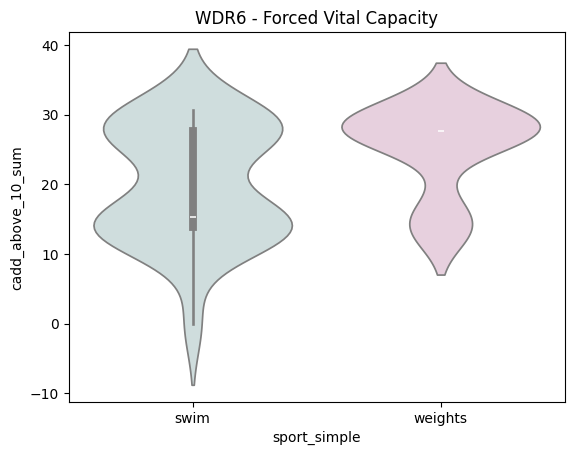

In [27]:
palette = ["#CCE0DF", "#EBCCDF"]

sns.violinplot(
    groups,
    x='sport_simple',
    y='cadd_above_10_sum',
    color='lightsteelblue',
    hue='sport_simple',
    palette=palette
    
).set(
    title='WDR6 - Forced Vital Capacity',
    #ylim=(-10,100)
)


### perform tests and export results

In [21]:
burden_opts = [
    'cadd_above_10_sum'
]

comparisons = [
    [['sport','control'],'group'],
    [['control','1kg'],'group'],
    [['1kg','sport'],'group'],
    [['endurance','speed'],'sport_type'],
    [['swim','weights'],'sport_simple']
]

groups = [['sport','group'],
          ['control','group'],
          ['1kg','group'],
          ['endurance','sport_type'],
          ['speed','sport_type'],
          ['swim', 'sport_simple'],
          ['weights', 'sport_simple']]

In [22]:
out = {
    f'{o}_{groups[0]}_vs_{groups[1]}_p_value': mt_single_grouped.apply(
        lambda df: ttest(df, groups, group_field, o)
    )
    for o in burden_opts
    for groups, group_field in comparisons
    }

/net/ascratch/people/plggosborcz/slurm_jobdir/6838963/tmp/ipykernel_4033051/51355450.py:2: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  pval = stats.ttest_ind(


In [23]:
stds = {
    f'{o}_{group}_std': mt_single_grouped.apply(
        lambda df: df[df[group_col] == group][o].std()
    )
    for o in burden_opts
    for group, group_col in groups
}

means = {
    f'{o}_{group}_mean': mt_single_grouped.apply(
        lambda df: df[df[group_col] == group][o].mean()
    )
    for o in burden_opts
    for group, group_col in groups
}

In [24]:
out.update(means)

In [25]:
out.update(stds)

In [26]:
df = pd.DataFrame(out)

In [27]:
for o in burden_opts:
    for groups, group_field in comparisons:
        df[
            f'{o}_{groups[0]}_vs_{groups[1]}_fdr'
        ] = fdrcorrection(
            df[
                f'{o}_{groups[0]}_vs_{groups[1]}_p_value'
            ].fillna(1),
            alpha=0.1    
        )[1]

In [28]:
df.loc[:, df.columns.str.contains('cadd_above_10_sum')].to_csv('burden-results.csv')

In [29]:
df = df.loc[:, df.columns.str.contains('cadd_above_10_sum')]

In [30]:
df.to_csv('burden-results.csv')

In [31]:
# get phenoos for each of the genes

sel_pheno_genes = gb.explode(gb.below_5)

In [32]:
genes = hl.literal(list(df.index))

In [33]:
sel_pheno_genes = sel_pheno_genes.filter(genes.contains(sel_pheno_genes.below_5))

In [34]:
sel_pheno_genes.count()

101

In [35]:
sel_pheno_genes = sel_pheno_genes.to_pandas()

In [35]:
sel_pheno_genes.to_csv('genebass_for_top_genes.csv')

### get burden for endurance vs speed only

- these are the following pgenotypes:

['allopurinol', 'Platelet crit', 'Immature reticulocyte fraction']

In [61]:
e_vs_genes = list(sel_pheno_genes[
    sel_pheno_genes['description'].isin(
        ['allopurinol',
         'Platelet crit',
         'Immature reticulocyte fraction'])]['below_5'])

In [62]:
e_vs_genes

['ABCG2',
 'ALDH16A1',
 'SLC22A12',
 'AC126283.2',
 'ACVRL1',
 'AHI1',
 'AMOTL1',
 'ATXN2',
 'BAK1',
 'BCL2L1',
 'BSN',
 'CD36',
 'CHEK2',
 'CUX2',
 'DCLRE1B',
 'EEF1AKMT4',
 'EEF1AKMT4-ECE2',
 'ITGA2B',
 'ITPR3',
 'JAK2',
 'KIF16B',
 'LAPTM5',
 'LEMD2',
 'LY75',
 'LY75-CD302',
 'MFSD2B',
 'NAA25',
 'NLRP3',
 'PIEZO1',
 'PLA2G12A',
 'PLEK',
 'PLSCR4',
 'POR',
 'RCL1',
 'S1PR4',
 'SH2B3',
 'SLA',
 'SLC1A1',
 'SLFN14',
 'TFR2',
 'THPO',
 'TIE1',
 'TNFRSF13B',
 'TUBB1',
 'YEATS2',
 'ZFAT',
 'ZNF469',
 'AL451136.1',
 'AMPD3',
 'ARHGAP21',
 'BSN',
 'CCDC124',
 'CCDC88B',
 'DOCK6',
 'EIF2AK1',
 'FERMT3',
 'GMPR',
 'HBB',
 'MFSD2B',
 'NKAPL',
 'OR10R2',
 'OSMR',
 'PELO',
 'PIEZO1',
 'QTRT1',
 'R3HDM4',
 'RIOK3',
 'RNF123',
 'RNF212',
 'S1PR2',
 'SLC45A4',
 'SLFN14',
 'SNX17',
 'SPHK1',
 'WASHC2C']

In [63]:
mt_single_e_vs_s = mt_single[mt_single['within_gene'].isin(e_vs_genes)]

In [64]:
mt_single_e_vs_s_grouped = mt_single_e_vs_s.groupby('within_gene')

In [65]:
burden_opts = [
    'cadd_above_10_sum'
]

comparisons = [
    [['sport','control'],'group'],
    [['control','1kg'],'group'],
    [['1kg','sport'],'group'],
    [['endurance','speed'],'sport_type'],
    [['swim','weights'],'sport_simple']
]

groups = [['sport','group'],
          ['control','group'],
          ['1kg','group'],
          ['endurance','sport_type'],
          ['speed','sport_type'],
          ['swim', 'sport_simple'],
          ['weights', 'sport_simple']]

In [66]:
out = {
    f'{o}_{groups[0]}_vs_{groups[1]}_p_value': mt_single_e_vs_s_grouped.apply(
        lambda df: utest(df, groups, group_field, o)
    )
    for o in burden_opts
    for groups, group_field in comparisons
    }

In [67]:
stds = {
    f'{o}_{group}_std': mt_single_e_vs_s_grouped.apply(
        lambda df: df[df[group_col] == group][o].std()
    )
    for o in burden_opts
    for group, group_col in groups
}

means = {
    f'{o}_{group}_mean': mt_single_e_vs_s_grouped.apply(
        lambda df: df[df[group_col] == group][o].mean()
    )
    for o in burden_opts
    for group, group_col in groups
}

In [68]:
out.update(means)

In [69]:
out.update(stds)

In [70]:
df = pd.DataFrame(out)

In [71]:
for o in burden_opts:
    for groups, group_field in comparisons:
        df[
            f'{o}_{groups[0]}_vs_{groups[1]}_fdr'
        ] = fdrcorrection(
            df[
                f'{o}_{groups[0]}_vs_{groups[1]}_p_value'
            ].fillna(1),
            alpha=0.1    
        )[1]

In [73]:
df.loc[:, df.columns.str.contains('cadd_above_10_sum')].to_csv('e-vs-s-burden-results.csv')

### get burden for swim vs weights only

- these are the following pgenotypes:

['Forced vital capacity (FVC), Best measure',
 'Date M81 first reported (osteoporosis without pathological fracture)']

In [36]:
s_vs_genes = list(sel_pheno_genes[
    sel_pheno_genes['description'].isin(
        ['Forced vital capacity (FVC), Best measure',
 'Date M81 first reported (osteoporosis without pathological fracture)'])]['below_5'])

In [37]:
s_vs_genes

['ADAMTS1',
 'ADAMTS6',
 'ATAD2',
 'CRISPLD2',
 'CRTAC1',
 'DDR2',
 'ESR1',
 'GATA5',
 'GRAMD2A',
 'HTRA1',
 'IHH',
 'LDLRAD4',
 'NIBAN2',
 'NPAS4',
 'PIEZO1',
 'SCMH1',
 'SLAMF9',
 'SMIM29',
 'SPARC',
 'STC2',
 'TGFB2',
 'TMEM181',
 'WDR6',
 'ZFAT',
 'LRP5',
 'PPP1R15A']

In [38]:
mt_single_e_vs_s = mt_single[mt_single['within_gene'].isin(s_vs_genes)]

In [39]:
mt_single_e_vs_s_grouped = mt_single_e_vs_s.groupby('within_gene')

In [40]:
burden_opts = [
    'cadd_above_10_sum'
]

comparisons = [
    [['sport','control'],'group'],
    [['control','1kg'],'group'],
    [['1kg','sport'],'group'],
    [['endurance','speed'],'sport_type'],
    [['swim','weights'],'sport_simple']
]

groups = [['sport','group'],
          ['control','group'],
          ['1kg','group'],
          ['endurance','sport_type'],
          ['speed','sport_type'],
          ['swim', 'sport_simple'],
          ['weights', 'sport_simple']]

In [43]:
out = {
    f'{o}_{groups[0]}_vs_{groups[1]}_p_value': mt_single_e_vs_s_grouped.apply(
        lambda df: ttest(df, groups, group_field, o)
    )
    for o in burden_opts
    for groups, group_field in comparisons
    }

/net/ascratch/people/plggosborcz/slurm_jobdir/6838963/tmp/ipykernel_4033051/51355450.py:2: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  pval = stats.ttest_ind(


In [ ]:
stds = {
    f'{o}_{group}_std': mt_single_e_vs_s_grouped.apply(
        lambda df: df[df[group_col] == group][o].std()
    )
    for o in burden_opts
    for group, group_col in groups
}

means = {
    f'{o}_{group}_mean': mt_single_e_vs_s_grouped.apply(
        lambda df: df[df[group_col] == group][o].mean()
    )
    for o in burden_opts
    for group, group_col in groups
}

In [ ]:
out.update(means)

In [ ]:
out.update(stds)

In [ ]:
df = pd.DataFrame(out)

In [ ]:
for o in burden_opts:
    for groups, group_field in comparisons:
        df[
            f'{o}_{groups[0]}_vs_{groups[1]}_fdr'
        ] = fdrcorrection(
            df[
                f'{o}_{groups[0]}_vs_{groups[1]}_p_value'
            ].fillna(1),
            alpha=0.1    
        )[1]

In [85]:
df.loc[:, df.columns.str.contains('cadd_above_10_sum')].to_csv('s-vs-w-burden-results.csv')